# Advanced Lane Line Findings

Note: All the process to detect lane lines in test video is executed in `process_image` function in `Defining image processing method` section. 

## Camera Calibration

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

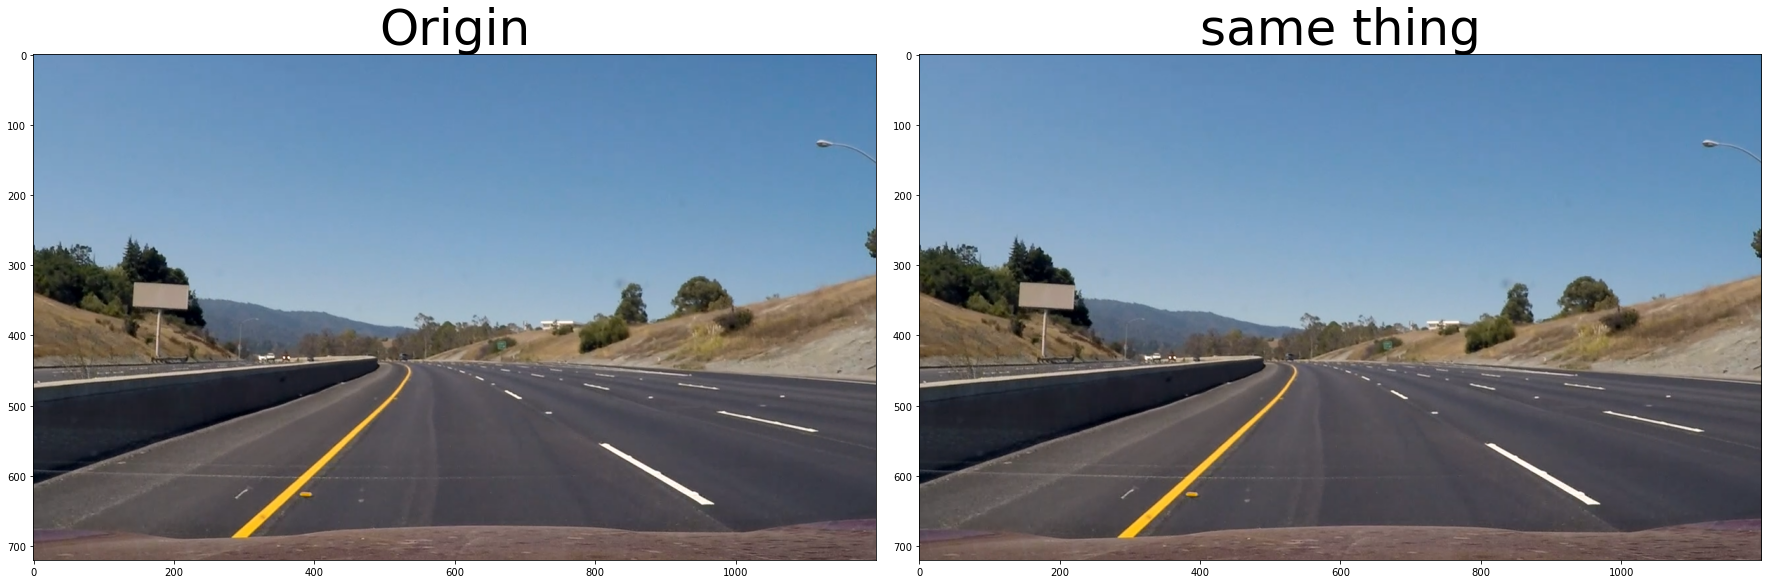

In [51]:
# def cal_undistort(img, objpoints, imgpoints):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None,None)
#     undist = cv2.undistort(img, mtx, dist, None, mtx)
#     return undist, mtx, dist
    #dist is distcoeffs it have 방사왜곡계수

# def collect_callibration_points():
#     objpoints = []
#     imgpoints = []
   
#     images = glob.glob('./camera_cal/calibration*.jpg')
#     objp = np.zeros((6*9,3), np.float32)   #54 by 3 float32 배열 생성
#     objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)
    
#     for fname in images:
#         img = mpimg.imread(fname)

#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

#         if ret == True:
#             imgpoints.append(corners)
#             objpoints.append(objp)
        
#     return imgpoints, objpoints

def compare_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    
    image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    
    ax1.imshow(image1_rgb, cmap='jet')
    ax1.set_title(image1_exp, fontsize=50)
    ax2.imshow(image2_rgb, cmap='jet')
    ax2.set_title(image2_exp, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    
# imgpoints, objpoints = collect_callibration_points()##피료업서
# img = mpimg.imread('./camera_cal/calibration3.jpg')
# undistorted, mtx, dist_coefficients = cal_undistort(img, objpoints, imgpoints)
image_path = './git_cloned/output/original.png'
before_image = cv2.imread(image_path)
image = cv2.resize(before_image, dsize=(1200, 720), interpolation=cv2.INTER_CUBIC)
compare_images(image, image, "Origin", "same thing")

# cv2.imshow('image', image)

# key = cv2.waitKey(0)
# if key == ord('q') :
#     cv2.destroyAllWindows()



# image, mtx, dist_coefficients = cal_undistort(image, objpoints, imgpoints)

## Gradient Thresholds

In [39]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) if orient == 'x' else np.zeros_like(gray)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) if orient == 'y' else np.zeros_like(gray)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) 
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1

    return dir_binary

def apply_thresholds(image, ksize=3):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

# image = cv2.imread('./lane_test/lane_test.png')
combined = apply_thresholds(image)

cv2.imshow('image', image)
cv2.imshow('combined', combined)

key = cv2.waitKey(0)
if key == ord('q') :
    cv2.destroyAllWindows()
# compare_images(image, combined, "Original Image", "Gradient Thresholds")

print(combined.shape)
print(type(combined))

(720, 1200)
<class 'numpy.ndarray'>


## Color Threshold

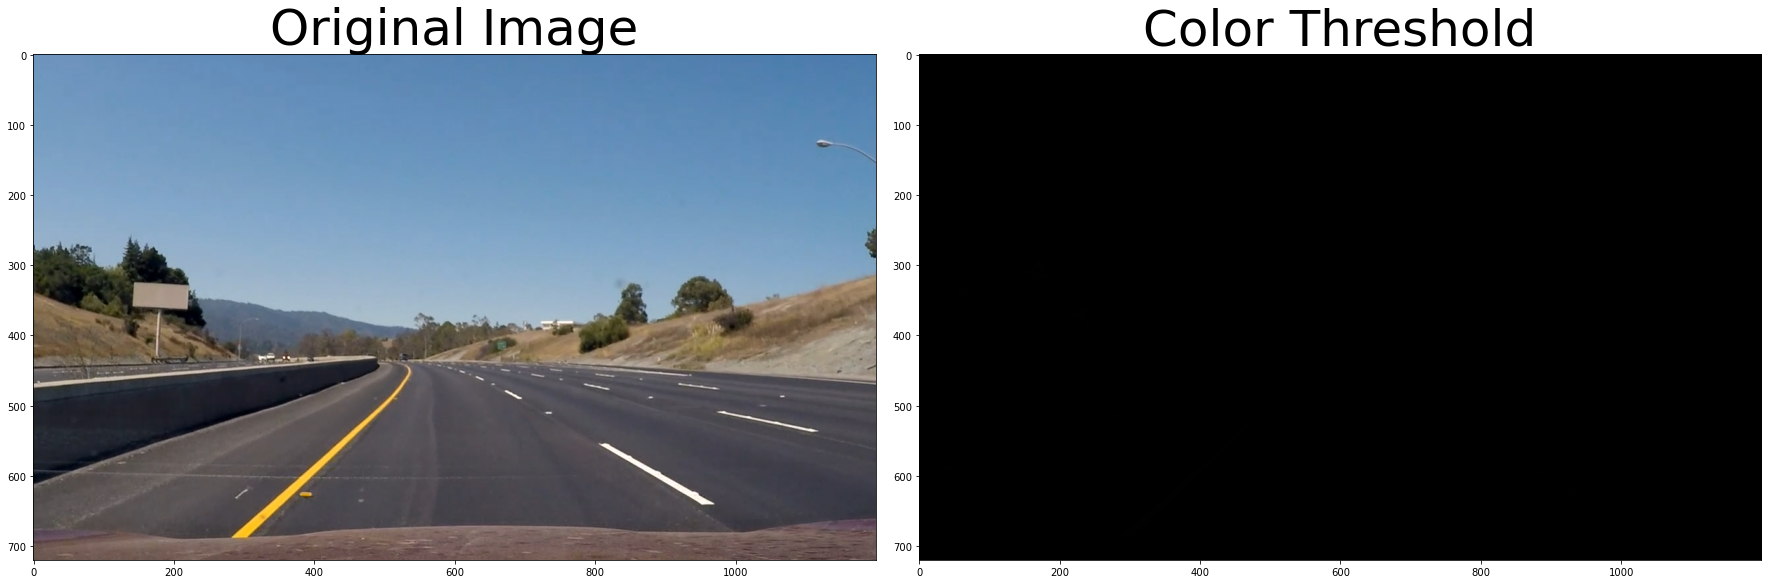

In [40]:
def apply_color_threshold(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    return s_binary
    
    
s_binary = apply_color_threshold(image)
compare_images(image, s_binary, "Original Image", "Color Threshold")

cv2.imshow('s_binary', s_binary)
cv2.imshow('image', image)
cv2.imshow('combined', combined)

key = cv2.waitKey(0)
if key == ord('q') :
    cv2.destroyAllWindows()

## Combine Color and Gradient

In [41]:
def combine_threshold(s_binary, combined):
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1

    return combined_binary


combined_binary = combine_threshold(s_binary, combined)
# compare_images(image, combined_binary, "Original Image", "Gradient and Color Threshold")

cv2.imshow('s_binary', s_binary)
cv2.imshow('image', image)
cv2.imshow('combined', combined)
cv2.imshow('combined_biary', combined_binary)

key = cv2.waitKey(0)
if key == ord('q') :
    cv2.destroyAllWindows()



## Perspective Transform

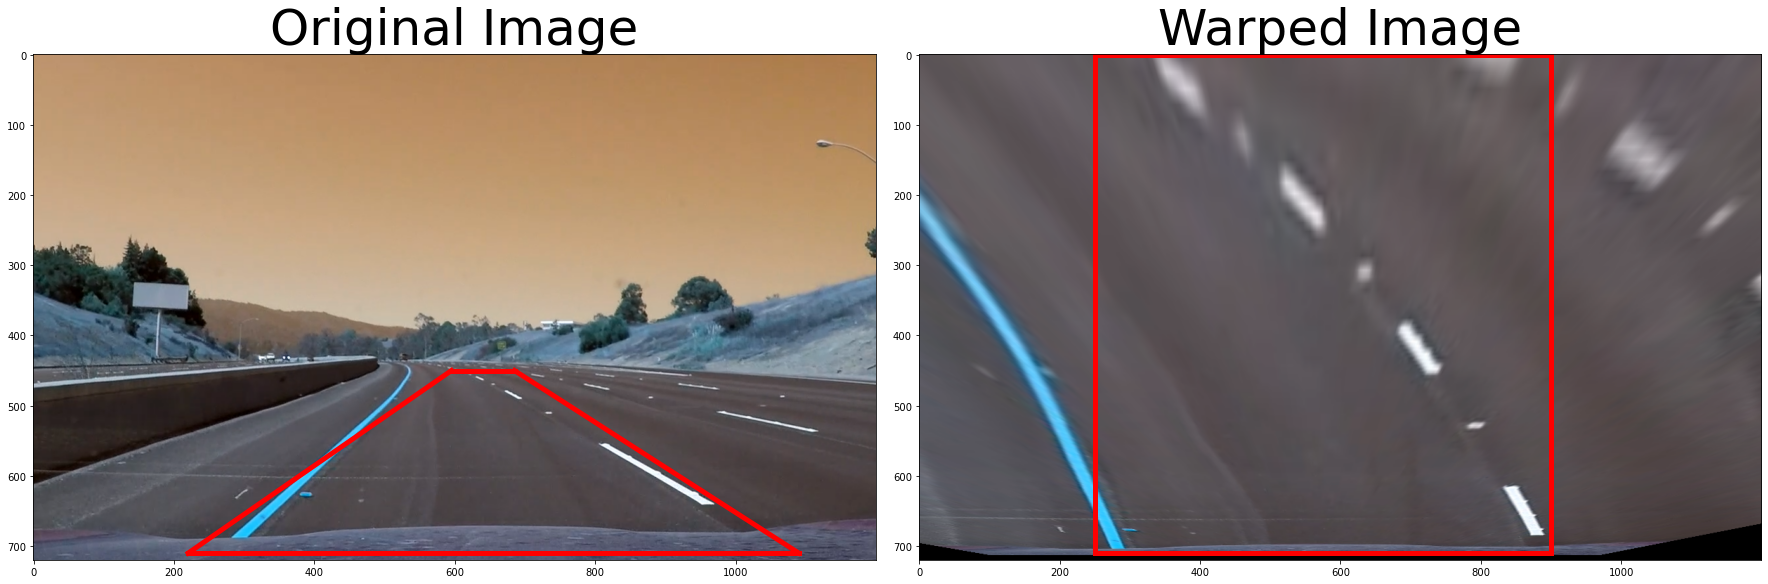

In [42]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[685, 450], 
          [1090, 710], 
          [220, 710], 
          [595, 450]])
    
    dst = np.float32(
        [[900, 0], 
          [900, 710], 
          [250, 710], 
          [250, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    binary_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
   
    return binary_warped, Minv

def compare_plotted_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.plot([685, 1090], [450, 710], color='r', linewidth="5")
    ax1.plot([1090, 220], [710, 710], color='r', linewidth="5")
    ax1.plot([220, 595], [710, 450], color='r', linewidth="5")
    ax1.plot([595, 685], [450, 450], color='r', linewidth="5")
    ax1.set_title(image1_exp, fontsize=50)
    ax2.imshow(image2)
    ax2.plot([900, 900], [0, 710], color='r', linewidth="5")
    ax2.plot([900, 250], [710, 710], color='r', linewidth="5")
    ax2.plot([250, 250], [710, 0], color='r', linewidth="5")
    ax2.plot([250, 900], [0, 0], color='r', linewidth="5")
    ax2.set_title(image2_exp, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    
warped, Minv = warp(image)
compare_plotted_images(image, warped, "Original Image", "Warped Image")


# cv2.imshow('warp', warped)
# cv2.imshow('image', image)
# cv2.imshow('combined', combined)
# cv2.imshow('combined_biary', combined_binary)

# key = cv2.waitKey(0)
# if key == ord('q') :
#     cv2.destroyAllWindows()


# Finding the Lines

## Histogram

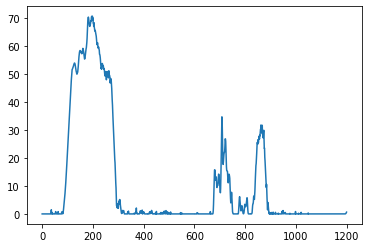

In [43]:
def get_histogram(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    return histogram
    
    
binary_warped, Minv = warp(combined_binary)
histogram = get_histogram(binary_warped)
plt.plot(histogram)

## Sliding Window

C:\Users\user\AppData\Local\Temp\ipykernel_33096\1210711689.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\user\AppData\Local\Temp\ipykernel_33096\1210711689.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release no

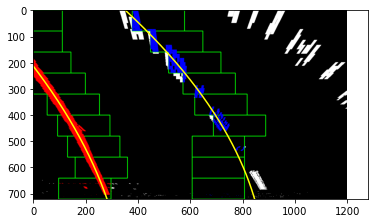

In [44]:
def slide_window(binary_warped, histogram):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return ploty, left_fit, right_fit

ploty, left_fit, right_fit = slide_window(binary_warped, histogram)

## Skipping Slinding Window

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


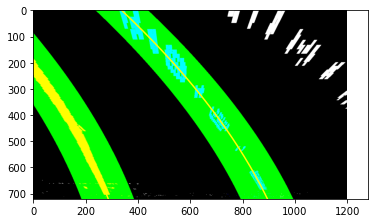

In [45]:
def skip_sliding_window(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
  
    
    ################################ 
    ## Visualization
    ################################ 
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    ret = {}
    ret['leftx'] = leftx
    ret['rightx'] = rightx
    ret['left_fitx'] = left_fitx
    ret['right_fitx'] = right_fitx
    ret['ploty'] = ploty
    
    return ret

draw_info = skip_sliding_window(binary_warped, left_fit, right_fit)

## Measuring Curvature

In [46]:
def measure_curvature(ploty, lines_info):
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 

    leftx = lines_info['left_fitx']
    rightx = lines_info['right_fitx']

    leftx = leftx[::-1]  
    rightx = rightx[::-1]  

    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad
    
left_curverad, right_curverad = measure_curvature(ploty, draw_info)

467.3929668965815 m 421.43346602675274 m


## Drawing

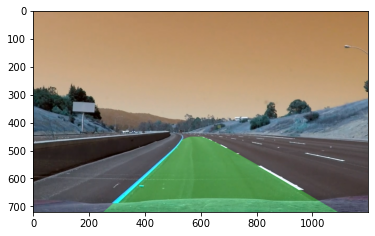

In [47]:
def draw_lane_lines(original_image, warped_image, Minv, draw_info):
    leftx = draw_info['leftx']
    rightx = draw_info['rightx']
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right_fitx']
    ploty = draw_info['ploty']
    
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0])) 
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    return result


result = draw_lane_lines(image, binary_warped, Minv, draw_info)
plt.imshow(result)

## Defining image processing method

In [48]:
global used_warped
global used_ret

def process_image(image):
    global used_warped
    global used_ret
    
    #Undistort image
    image, mtx, dist_coefficients = cal_undistort(image, objpoints, imgpoints)
    
    # Gradient thresholding
    gradient_combined = apply_thresholds(image)
   
    # Color thresholding
    s_binary = apply_color_threshold(image)
    
    # Combine Gradient and Color thresholding
    combined_binary = combine_threshold(s_binary, gradient_combined)
   
    # Transforming Perspective
    binary_warped, Minv = warp(combined_binary)
  
    # Getting Histogram
    histogram = get_histogram(binary_warped)
  
    # Sliding Window to detect lane lines
    ploty, left_fit, right_fit = slide_window(binary_warped, histogram)
    
    # Skipping Sliding Window
    ret = skip_sliding_window(binary_warped, left_fit, right_fit)
   
    # Measuring Curvature
    left_curverad, right_curverad = measure_curvature(ploty, ret)
    
     # Sanity check: whether the lines are roughly parallel and have similar curvature
    slope_left = ret['left_fitx'][0] - ret['left_fitx'][-1]
    slope_right = ret['right_fitx'][0] - ret['right_fitx'][-1]
    slope_diff = abs(slope_left - slope_right)
    slope_threshold = 150
    curve_diff = abs(left_curverad - right_curverad)
    curve_threshold = 10000
    
    if (slope_diff > slope_threshold or curve_diff > curve_threshold):
        binary_warped = used_warped
        ret = used_ret
   
    # Visualizing Lane Lines Info
    result = draw_lane_lines(image, binary_warped, Minv, ret)
    
    # Annotating curvature 
    fontType = cv2.FONT_HERSHEY_SIMPLEX
    curvature_text = 'The radius of curvature = ' + str(round(left_curverad, 3)) + 'm'
    cv2.putText(result, curvature_text, (30, 60), fontType, 1.5, (255, 255, 255), 3)
   
    # Annotating deviation
    deviation_pixels = image.shape[1]/2 - abs(ret['right_fitx'][-1] - ret['left_fitx'][-1])
    xm_per_pix = 3.7/700 
    deviation = deviation_pixels * xm_per_pix
    direction = "left" if deviation < 0 else "right"
    deviation_text = 'Vehicle is ' + str(round(abs(deviation), 3)) + 'm ' + direction + ' of center'
    cv2.putText(result, deviation_text, (30, 110), fontType, 1.5, (255, 255, 255), 3)
    
    used_warped = binary_warped
    used_ret = ret
    
    return result 

#result_image = process_image(image)
#plt.imshow(result_image)

## Applying to Video 

In [13]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(process_image) 
%time video_clip.write_videofile(output, audio=False)

NameError: name 'VideoFileClip' is not defined